# Planar Atmosphere

MCRT simulation for a planar atmosphere. Photons are isotropically scattered, where every step a photon packet takes is a scattering event.

In [1]:
import timeit
import numpy as np
from matplotlib import pyplot as plt

# Classes

In [2]:
class Photon_Packet(object):

    def __init__(self):
        """
        Initalise the photon packet.
        """

        self._coords = np.array([0, 0, 0], dtype=np.float)
        self._costheta = np.sqrt(np.random.rand())
        self._sintheta = np.sqrt(1 - self._costheta ** 2)
        self._phi = 2 * np.pi * np.random.rand()
        self._cosphi = np.cos(self._phi)
        self._sinphi = np.sin(self._phi)
        self._escaped = False

    def _scatter_packet(self):
        """
        Isotropic scattering of the photon packet, i.e. change the direction
        it propagates.
        """

        self._costheta = 2 * np.random.rand() - 1
        self._sintheta = np.sqrt(1 - self._costheta ** 2)
        self._phi = 2 * np.pi * np.random.rand()
        self._cosphi = np.cos(self._phi)
        self._sinphi = np.sin(self._phi)

    def _transport_packet(self, tau_max, albedo):
        """
        Transports the photon packets through the atmosphere.
        
        Parameters
        ----------
        tau_max: float.
            The maximum optical depth in the atmosphere.
        albedo: float.
            The scattering probabilty. 
        """

        while self._coords[2] >= 0 and self._coords[2] <= 1:
            # sample an optical depth and update the position of the packet
            tau = -np.log(np.random.rand())
            L = tau/tau_max
            self._coords[0] += L * self._sintheta * self._cosphi
            self._coords[1] += L * self._sintheta * self._sinphi
            self._coords[2] += L * self._costheta

            if np.random.rand() < albedo and self._coords[2] >= 0 and \
                    self._coords[2] <= 1:
                self._scatter_packet()

            # if z < 0, the photon has travelled deeper into the atmosphere
            # and is lost, hence restart the photon
            if self._coords[2] < 0:
                self.__init__()

            # if z > 1, the photon has escaped the atmosphere
            if self._coords[2] > 1:
                self._escaped = True

# Functions

In [3]:
def bin_photons(mu, mu_bins, n_photons):
    """
    Bins the photons into corresponding angle bins corresponding to the
    direction they left the atmosphere.

    Parameters
    ----------
    mu: (1 x n_photons) array of floats.
        The angle mu = cos(theta) for which the photon packets exited
        the atmospehre.
    mu_bins: integer.
        The number of theta angles to bin for.
    n_photons: integer.
        The total number of photon packets.

    Returns
    -------
    mu_hist: (1 x mu_bins) array of ints.
        The number of photons packets which left the atmosphere at one
        of the binned angles.
    theta: (1 x mu_bins) array of floats.
        The binned theta angles.
    """

    theta = np.zeros(mu_bins)
    mu_hist = np.zeros(mu_bins)

    # calculate the binned theta angles
    dtheta = 1/mu_bins
    half_width = 0.5 * dtheta  # see kenny wood's code for half_width...?
    for i in range(mu_bins):
        theta[i] = np.arccos(i * dtheta + half_width) * (180/np.pi)

    # bin the mu = cos(theta) angles for each photon accordingly
    for i in range(n_photons):
        j = abs(int(mu[i] * mu_bins))
        mu_hist[j] = mu_hist[j] + 1

    return mu_hist, theta


def photon_moments(mu_bins, mu_hist, theta):
    """
    Calculate the mean intensity for the bin angles.

    Parameters
    ----------
    mu_bins: integer.
        The number of theta angle bins.
    mu_hist: (1 x mu_bins) array of ints.
        The number of photons packets which left the atmosphere at one
        of the binned angles.
    theta: (1 x mu_bins) array of floats.
        The binned theta angles.

    Returns
    -------
    intensity: (1 x mu_bins) array of floats.
        The intensity estimated via the number of photon for each binned angle.
    """

    intensity = np.zeros(mu_bins)
    for i in range(mu_bins):
        intensity[i] = (mu_hist[i] * mu_bins)/(2 * np.sum(mu_hist) *
                                               np.cos(theta[i] * np.pi/180))

    return intensity

# Simulation

In [13]:
print('Beginning Simulation...\n')

n_photons = int(10e4)
mu_bins = 10
tau_max = 10
albedo = 1

start = timeit.default_timer()

mu = np.zeros(n_photons)
phi = np.zeros(n_photons)
for packet in range(n_photons):
    photon_packet = Photon_Packet()
    photon_packet._transport_packet(tau_max, albedo)
    if photon_packet._escaped is True:
        mu[packet] = photon_packet._costheta
        phi[packet] = photon_packet._phi

    if ((packet + 1) % 10000 == 0):
        percent_complete = 100 * (packet + 1)/n_photons
        print('{} photons ({:3.1f}%) transported.'
              .format(packet + 1, percent_complete))

mu_hist, theta = bin_photons(mu, mu_bins, n_photons)
energy_absorbed = mu_hist/n_photons
intensity = photon_moments(mu_bins, mu_hist, theta)

stop = timeit.default_timer()

print('\nTransport of {} packets completed in {:3.2f} seconds.'
      .format(n_photons, stop - start))

Beginning Simulation...

10000 photons (10.0%) transported.
20000 photons (20.0%) transported.
30000 photons (30.0%) transported.
40000 photons (40.0%) transported.
50000 photons (50.0%) transported.
60000 photons (60.0%) transported.
70000 photons (70.0%) transported.
80000 photons (80.0%) transported.
90000 photons (90.0%) transported.
100000 photons (100.0%) transported.

Transport of 100000 packets completed in 290.15 seconds.


# Plots

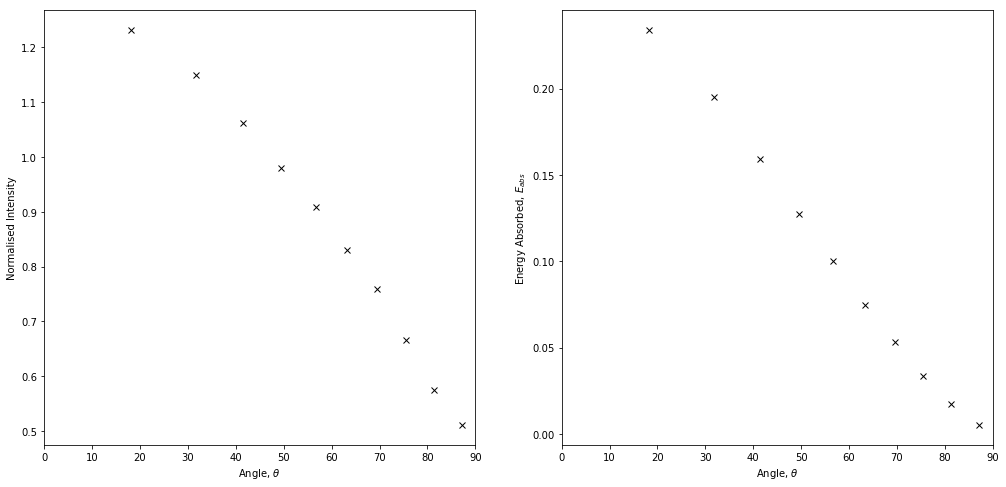

In [16]:
fig = plt.figure(figsize=(17, 8))

# plot the intensity against angle
ax1 = fig.add_subplot(121)
ax1.plot(theta, intensity, 'kx')
ax1.set_xlabel(r'Angle, $\theta$')
ax1.set_ylabel(r'Normalised Intensity')
ax1.set_xlim(0, 90)

# plot the energy absorbed against angle
ax2 = fig.add_subplot(122)
ax2.plot(theta, energy_absorbed, 'kx')
ax2.set_xlabel(r'Angle, $\theta$')
ax2.set_ylabel(r'Energy Absorbed, $E_{abs}$')
ax2.set_xlim(0, 90)

plt.show()